## 分类算法：以MNIST为例

B站地址：https://www.bilibili.com/video/av43395877/

之前我们做了数值拟合的程序，他们得到的结果仅仅是一个数，得到的误差函数也仅仅是使用了误差平方和的形式。

现在考虑分类问题，分类问题最重要的是把正确的类别识别出来，得到的结果并不是完全是像拟合任务一样，label值并不是单纯的可以比较大小的数值，所以上述误差函数并不是特别适用。

### 结果的表示

为了实现分类的效果，我们需要用一种形式来表明结果代表的含义。

之前在拟合异或的时候，曾经提到过，异或的结果0或者1可以被认为是一种分类，所以二分类可以简单使用0到1的值（通过sigmoid函数即可）。但是，如果多分类采用0，1，2，3等数值来表示，相当于给定了一个大小关系与排列顺序，这是不科学的。

#### one-hot编码&softmax

一共有N种可能的分类，则可以使用一个长度为N的数组，每个元素均为0-1的数，总和为1。

softmax函数用来归一化，即把所有的数据变到0-1的区间，同时保证其和为1.

- 为了能够变为0或者正数，将每一个数据都用指数函数处理；
- 为了能够保证和为1，把所有元素都除以总和，加起来就是1.

函数形式为：

- $\frac{e^{a_m}}{\sum\limits_{i=1}^{n} e^{a_i}}$

计算的时候，为了避免指数计算得到全是0或者极大值，可以让所有的$a_i$全都增加或减小一个数$M$（相当于分子分母都同时乘上$e^M$）。比如直接取$-\max \{a_i\}$

具体的编码方式：
- 表示标签数据时，可以直接将它代表的标签那一位置为1，其余置为0，即所谓one-hot编码；
- 神经网络的输出设置为长度为N的数组，最后计算得到的结果，使用softmax函数确定。

### loss函数的确定

#### 信息熵

变量的不确定性越大，熵也越大，即把它搞清楚所需要的信息量也越大。

信息熵的公式是：$\sum\limits_{i=1}^n p_i \ln \frac 1 {p_i} = -\sum\limits_{i=1}^n p_i \ln {p_i}$

*注：ln代表以2为底*

比如网上看到的一个编码问题：

> 如果有A、B、C、D这四个字符组成的内容，每个字符出现的概率都是1/4，即概率分布为{1/4，1/4，1/4，1/4}，设计一个最短的编码方案来表示一组数据，套用刚才的公式：
> 
> 算出来信息熵为2，即需要2bit来表示。如果第1位0表示A，1表示B；第2位0表示C，1表示D，2位编码搞定。
> 
> 如果概率变了，比如A、B、C、D出现的概率是{0，0，1/2，1/2}，即：每次A、B必然不出现，C、D出现机会各占一半，这样只要1位就可以了。1表示C，0表示D，因为AB必然不出现，不用表示都知道肯定不用AB，套用公式算出来的结果也是如此（注意0ln0需要使用极限来算，得到0）。

#### 交叉熵

$H(x,y)=-\sum\limits_{i=1}^n x_i\ln y_i$，这里x是已知的概率分布，y是自己算出来的概率分布，结果越小表明越接近。

本质上来说，它来源于极大似然函数。考虑$p(t|x) = \prod_{i=1}^{C}P(t_i|x)^{t_i} = \prod_{i=1}^{C}y_i^{t_i}$，其中$t$代表我们实际得到的标签，$y$或者$P(t_i |x)$指计算得到的结果，取对数即为上述交叉熵。

交叉熵得到的是单个样本的误差，再次求平均得到的就是这一批次样本的总的误差。

之前的训练过程中，因为所有样本全部参与训练，所以求平均一步也写成了求和；但是对于样本不一定个数相同的情况，还是写成求平均（reduce_mean）。

##### 交叉熵在tensorflow中的实现

我们在softmax之后，可以直接用`tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), reduction_indices=[1]))`来得到所有样本交叉熵的平均值。

其中reduction_indices表示在第几个维度上进行reduce，这里是首先对于一个样本中的元素进行reduce，得到的就是一个样本的交叉熵。

![reduction_indices](Tensorflow05-MNIST.assets/v2-c92ac5c3a50e4bd3d60e29c2ddc4c5e9_r.png)

但是为了方便起见，我们可以直接使用`tf.nn.softmax_cross_entropy_with_logits`来进行softmax和交叉熵计算的操作。

参考：

- https://baike.baidu.com/item/%E4%BF%A1%E6%81%AF%E7%86%B5
- https://www.imooc.com/article/30013
- https://zhuanlan.zhihu.com/p/27223959
- http://www.cnblogs.com/likethanlove/p/6547405.html

## MNIST网络构建

### 数据读入

现在还可以直接使用官方提供的mnist数据集及其相关函数，但是其中一些会很快被弃用：

- 数据集使用：`from tensorflow.examples.tutorials.mnist import input_data`
- 读取数据集中数据：`mnist = input_data.read_data_sets('MNIST_data', one_hot=True)`
- 数据集中可以分批读入数据，使用`mnist.train.next_batch(100)`每次读入100个数据。

MNIST数据集中的元素都是长度为$28*28=784$的数组，所以输入矩阵的大小为`[None, 784]`，label的大小为`[None, 10]`，这里为了简单，不设置更多层，直接在一个线性模型后面接上softmax来进行计算。

*注：建议提前下载并且保存MNIST数据集到本地MNIST_data文件夹中，避免下载用时过长*

具体代码如下，参考https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-01-classifier/ ：

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

def add_layer(inputs, in_size, out_size, activation_function=None):
    Weights = tf.Variable(tf.random_normal([in_size, out_size]))
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys})
    return result

xs = tf.placeholder(tf.float32, [None, 28 * 28])
ys = tf.placeholder(tf.float32, [None, 10])

prediction = add_layer(xs, 28 * 28, 10, activation_function=tf.nn.softmax)

# 交叉熵作为loss函数，内层计算得到一个样本的loss，之后平均得到整体的样本loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),
                                              reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys})
        if i % 50 == 0:
            print(compute_accuracy(mnist.test.images, mnist.test.labels))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
0.1037
0.6313
0.7415
0.782
0.8066
0.8228
0.8295
0.8361
0.8446
0.8512
0.8577
0.8607
0.866
0.8643
0.8669
0.8727
0.8698
0.8729
0.8743
0.8778


如果需要自己手动加载数据集，则可以使用如下方法（来自https://blog.csdn.net/simple_the_best/article/details/75267863）：

首先解压下载好的四个MNIST数据压缩包，放入同一个文件夹中（比如我放到了`MNIST_data`文件夹中）。

之后使用大端序进行读取，读完前面的magic number和个数信息后，将剩余的数据作为numpy数组进行读取。

In [2]:
%matplotlib inline

5
0
4
1
9
2
1
3
1
4


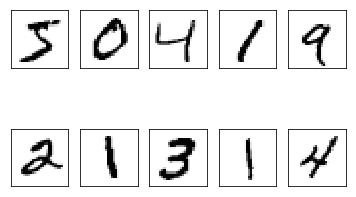

In [17]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels.idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images.idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

images, labels = load_mnist('MNIST_data')

fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True) # share坐标轴以便于后续去除坐标轴

ax = ax.flatten()
for i in range(10):
    img = images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    print(labels[i])

# 去掉坐标轴
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()